# Limited Feature Random Forest Notebook
## Adapted from model_training.ipynb

This runs most of the same code as in model_training.ipynb but with the bulk of it put into functions for easier reusing. Then a new random forest PKL file is created taking the top ten most important features.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap

/Users/far/Desktop/desd/desd_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42) 

claims_data = pd.read_csv('ProcessedClaimData.csv')



ANALYZING DUPLICATES IN THE DATASET
Number of complete duplicate rows: 0

Top 10 most frequent settlement values:
SettlementValue
520.0     304
895.0     198
260.0     146
495.0     142
240.0     119
840.0      63
1390.0     49
1020.0     26
795.0      21
950.0      20
Name: count, dtype: int64


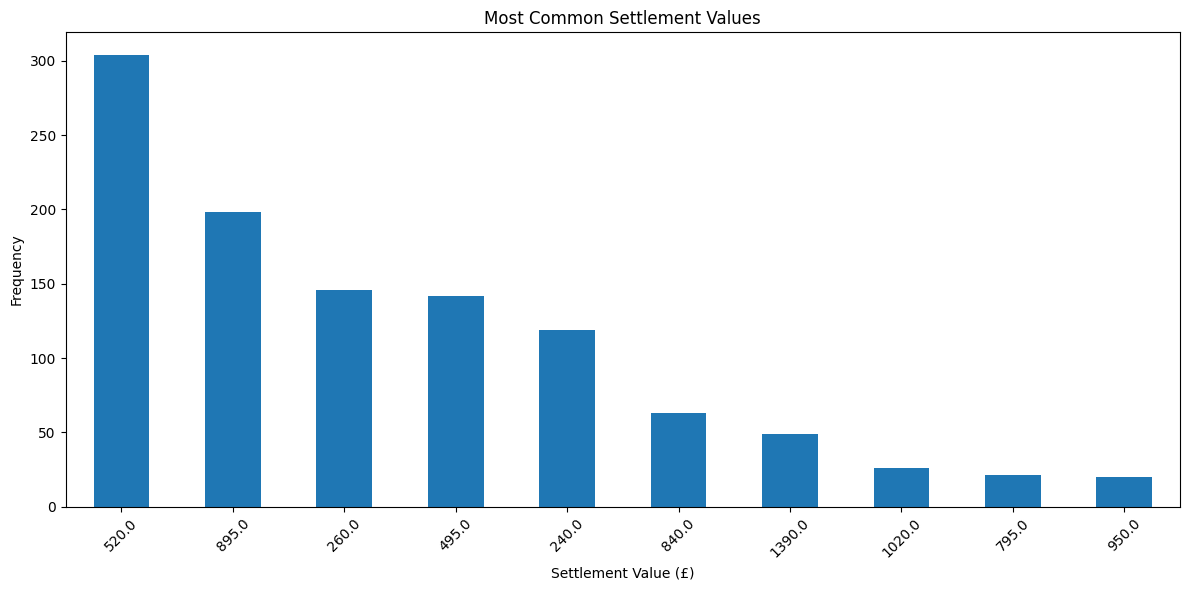


potential pattern duplicates
Rows with duplicate patterns across key features: 3085

Most common claim patterns:
AccidentType  InjuryPrognosis  DominantInjury  VehicleType
Rear end      6                Arms            Car            51
                               Hips            Car            51
                               Arms            Motorcycle     50
                               Legs            Truck          50
                               Multiple        Car            49
                               Legs            Car            46
                               Multiple        Truck          44
                               Arms            Truck          41
                               Multiple        Motorcycle     41
              5                Multiple        Car            38
dtype: int64


In [3]:
print("\n\n" + "="*50)
print("ANALYZING DUPLICATES IN THE DATASET")
print("="*50)

# Check for complete duplicates
duplicate_rows = claims_data.duplicated().sum()
print(f"Number of complete duplicate rows: {duplicate_rows}")

# Analyze settlement value distribution
settlement_counts = claims_data['SettlementValue'].value_counts().head(10)
print("\nTop 10 most frequent settlement values:")
print(settlement_counts)

plt.figure(figsize=(12, 6))
settlement_counts.plot(kind='bar')
plt.title('Most Common Settlement Values')
plt.xlabel('Settlement Value (£)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check for partial duplicates in key feature combinations
print("\npotential pattern duplicates")
key_features = ['AccidentType', 'InjuryPrognosis', 'DominantInjury', 'VehicleType']
pattern_dupes = claims_data.duplicated(subset=key_features).sum()
print(f"Rows with duplicate patterns across key features: {pattern_dupes}")

if pattern_dupes > 0:
    # Show the most common patterns
    pattern_counts = claims_data.groupby(key_features).size().sort_values(ascending=False).head(10)
    print("\nMost common claim patterns:")
    print(pattern_counts)

In [4]:
def identify_columns(claims_data):
    # Identify categorical and numerical columns
    categorical_cols = claims_data.select_dtypes(include=['object', 'string']).columns.tolist()
    numerical_cols = claims_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Remove the target variable from the feature lists
    target_col = 'SettlementValue'

    # Remove both the log-transformed target AND the original settlement value from features
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    
    # adding it later
    if 'LogSettlementValue' in numerical_cols:
        numerical_cols.remove('LogSettlementValue')

    print(f"\nCategorical columns: {categorical_cols}")
    print(f"Numerical columns: {numerical_cols}")
    print(f"Target column: {target_col}")

    return categorical_cols, numerical_cols, target_col

def define_preprocessor(X_train):
    categorical_cols, numerical_cols, _ = identify_columns(claims_data=claims_data)

    categorical_cols = [col for col in categorical_cols if col in X_train.columns]
    numerical_cols = [col for col in numerical_cols if col in X_train.columns]

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
    ])

    return preprocessor, categorical_cols, numerical_cols

# Function to evaluate a model
def evaluate_model(model, X, y, model_name, log_transform=True):
    y_pred = model.predict(X)
    
    # Calculate metrics on log scale
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Calculate metrics on original GBP scale
    if log_transform:
        y_pounds = np.expm1(y)
        y_pred_pounds = np.expm1(y_pred)
        mse_pounds = mean_squared_error(y_pounds, y_pred_pounds)
        rmse_pounds = np.sqrt(mse_pounds)
        mae_pounds = mean_absolute_error(y_pounds, y_pred_pounds)
    else:
        y_pounds = y
        y_pred_pounds = y_pred
        mse_pounds = mse
        rmse_pounds = rmse
        mae_pounds = mae
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2,
        'Name': model_name,
        'MSE_GBP': mse_pounds,
        'RMSE_GBP': rmse_pounds,
        'MAE_GBP': mae_pounds,
        'y_pred': y_pred,
        'y_pred_GBP': y_pred_pounds
    }


In [5]:
def execute_pipeline(models, preprocesser, X_train, y_train, X_val, y_val):
    # Dictionary to store model results
    model_results = {}
    print("\nTraining and evaluating models:")

    for name, model in models.items():
        start_time = time.time()
        
        # Create pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocesser),
            ('model', model)
        ])
        
        # Train the model
        print(f"Training {name}...")
        pipeline.fit(X_train, y_train)
        
        # Evaluate on validation set
        results = evaluate_model(pipeline, X_val, y_val, name)
        results['Training Time'] = time.time() - start_time
        model_results[name] = results
        
        print(f"  {name} - RMSE: {results['RMSE']:.2f}, R^2: {results['R^2']:.4f}, Time: {results['Training Time']:.2f}s")
        print(f"  Error in GBP - RMSE: £{results['RMSE_GBP']:.2f}, MAE: £{results['MAE_GBP']:.2f}")
        
        # Store the pipeline
        model_results[name]['pipeline'] = pipeline

    # Using RMSE to compare the models
    best_model_name = min(model_results, key=lambda k: model_results[k]['RMSE'])
    print(f"\nBest model based on validation RMSE: {best_model_name}")
    best_pipeline = model_results[best_model_name]['pipeline']

    return best_model_name, best_pipeline, model_results

def model_tuner(best_pipeline, param_grid, model_results, X_train, y_train, X_val, y_val):
    # Only performs hyperparameter tuning if we have parameters to tune
    if param_grid:
        best_model_name = best_pipeline.named_steps['model'].__class__.__name__
        
        print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
        
        # Cross validation 
        grid_search = GridSearchCV(
            best_pipeline,
            param_grid,
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        print(f"Best parameters: {grid_search.best_params_}")
        best_pipeline = grid_search.best_estimator_
        
        tuned_results = evaluate_model(best_pipeline, X_val, y_val, f"{best_model_name} (Tuned)")
        print(f"Tuned model - RMSE: {tuned_results['RMSE']:.2f}, R^2: {tuned_results['R^2']:.4f}")
        print(f"Error in GBP - RMSE: £{tuned_results['RMSE_GBP']:.2f}, MAE: £{tuned_results['MAE_GBP']:.2f}")
        
        model_results[f"{best_model_name} (Tuned)"] = tuned_results
        model_results[f"{best_model_name} (Tuned)"]["pipeline"] = best_pipeline
        
        if tuned_results['RMSE'] < model_results[best_model_name]['RMSE']:
            best_model_name = f"{best_model_name} (Tuned)"

    return best_pipeline, best_model_name, model_results

In [6]:
if 'AccidentDate' in claims_data.columns and 'ClaimDate' in claims_data.columns:
    claims_data['DaysBetweenAccidentAndClaim'] = claims_data['ClaimDate'] - claims_data['AccidentDate']

categorical_cols, numerical_cols, target_col = identify_columns(claims_data=claims_data)


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


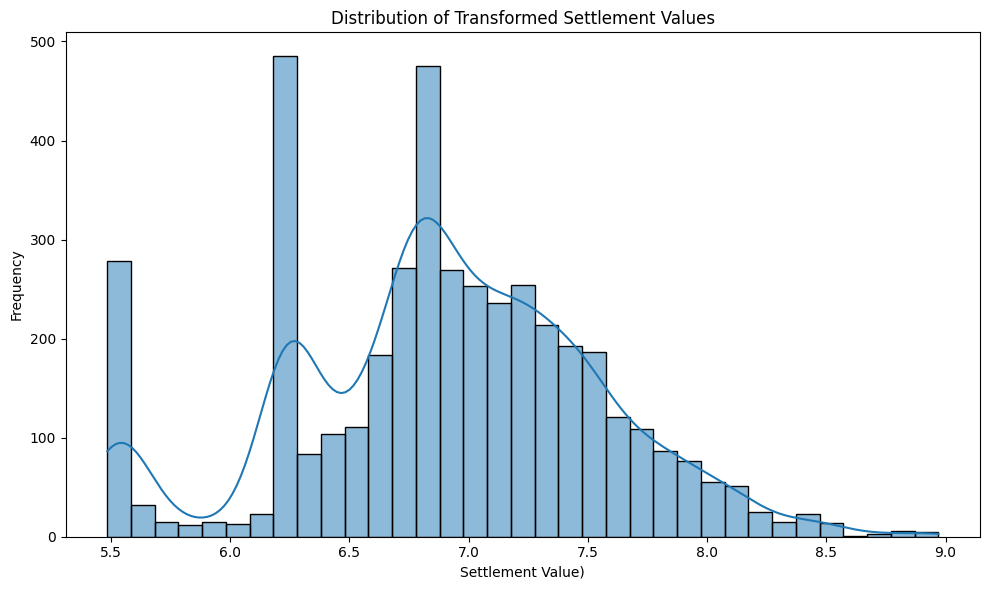

In [7]:

claims_data['SettlementValue'] = np.log1p(claims_data[target_col])
plt.figure(figsize=(10, 6))
sns.histplot(claims_data['SettlementValue'], kde=True)
plt.title('Distribution of Transformed Settlement Values')
plt.xlabel('Settlement Value)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show() 

In [8]:
skewness = claims_data[target_col].skew()
print(f"Skewness of target variable: {skewness}")

Skewness of target variable: -0.1198202207576095


In [9]:
log_transform = False
if abs(skewness) > 1:
    log_transform = True
    claims_data['LogSettlementValue'] = np.log1p(claims_data[target_col])
    target_col= 'LogSettlementValue'
    
    sns.histplot(claims_data['LogSettlementValue'], kde=True)
    plt.title('Log-Transformed Settlement Values')
    plt.tight_layout()
    plt.show()
    
    print(f"\nApplied log transformation due to skewness. New target column: {target_col}")
    skewness = claims_data[target_col].skew()
    print(f"Skewness of target variable: {skewness}")
else:
    target_col = target_col
    print("\nTarget variable is not highly skewed, using original values.")


Target variable is not highly skewed, using original values.


In [10]:

# Splitting data
X = claims_data.drop(columns=[target_col])
if 'SettlementValue' in X.columns:
    X = X.drop(columns=['SettlementValue'])
    
y = claims_data[target_col]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 2577 samples
Validation set size: 860 samples
Test set size: 860 samples


In [11]:
# Define a list of models to try
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

preprocessor_tuple = define_preprocessor(claims_data)
preprocessor_obj = preprocessor_tuple[0]  # Extract just the preprocessor object

best_model_name, best_pipeline, model_results = execute_pipeline(
    models=models, 
    preprocesser=preprocessor_obj,  # Pass just the preprocessor object
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)
# Tuning the best hyperparameter Tuning for the Best Model
param_grid = {}

if best_model_name == 'LinearRegression':
    # regression model does not have hyperparameters to tune but best to keep this to keep track 
    pass
elif best_model_name == 'Ridge':
    param_grid = {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
elif best_model_name == 'RandomForestRegressor':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
    }


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue

Training and evaluating models:
Training LinearRegression...
  LinearRegression - RMSE: 0.37, R^2: 0.6860, Time: 0.22s
  Error in GBP - RMSE: £46556.99, MAE: £1863.85
Training Ridge...
  Ridge - RMSE: 0.37, R^2: 

In [12]:
best_pipeline, best_model_name, model_results = model_tuner(
    best_pipeline, 
    param_grid, 
    model_results,
    X_train,
    y_train,  
    X_val,    
    y_val     
)
# Evaluate the best model on the test set
best_pipeline = model_results[best_model_name]['pipeline']
test_results = evaluate_model(best_pipeline, X_test, y_test, best_model_name)
print(f"\nTest set evaluation for {best_model_name}:")
print(f"  RMSE: {test_results['RMSE']:.2f}")
print(f"  MAE: {test_results['MAE']:.2f}")
print(f"  R^2: {test_results['R^2']:.4f}")


Performing hyperparameter tuning for RandomForestRegressor...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Tuned model - RMSE: 0.20, R^2: 0.9055
Error in GBP - RMSE: £331.09, MAE: £156.05

Test set evaluation for RandomForestRegressor (Tuned):
  RMSE: 0.18
  MAE: 0.10
  R^2: 0.9214


In [13]:
def predicted_settlement_plot(y_pred_test, y_test, best_model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Settlement Values')
    plt.ylabel('Predicted Settlement Values')
    plt.title(f'Actual vs. Predicted Settlement Values ({best_model_name})')
    plt.tight_layout()
    plt.show()

def residual_plot(y_test, y_pred_test):
    # Calculate residuals
    residuals = y_test - y_pred_test

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Settlement Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.tight_layout()
    plt.show()

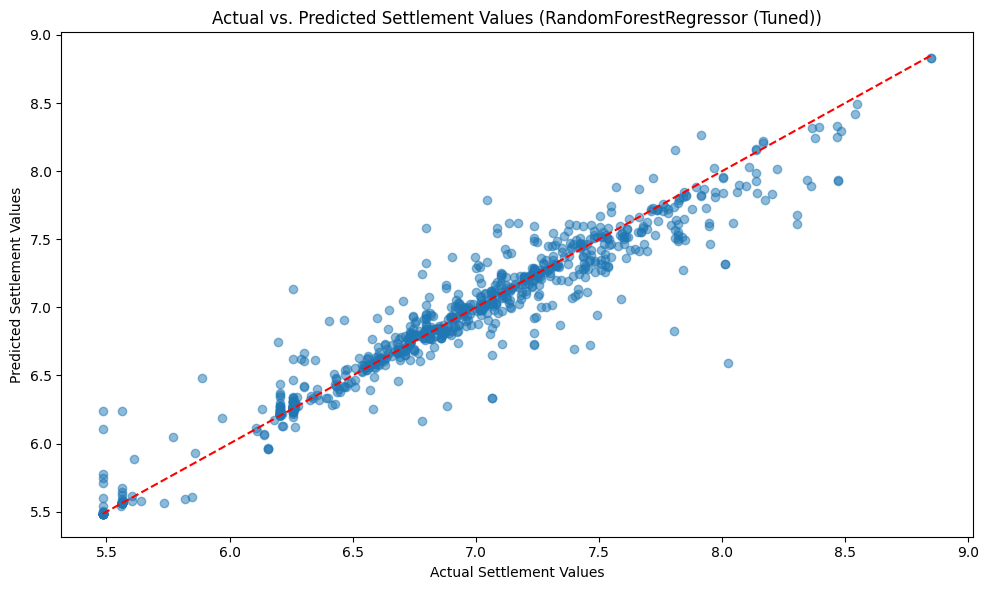

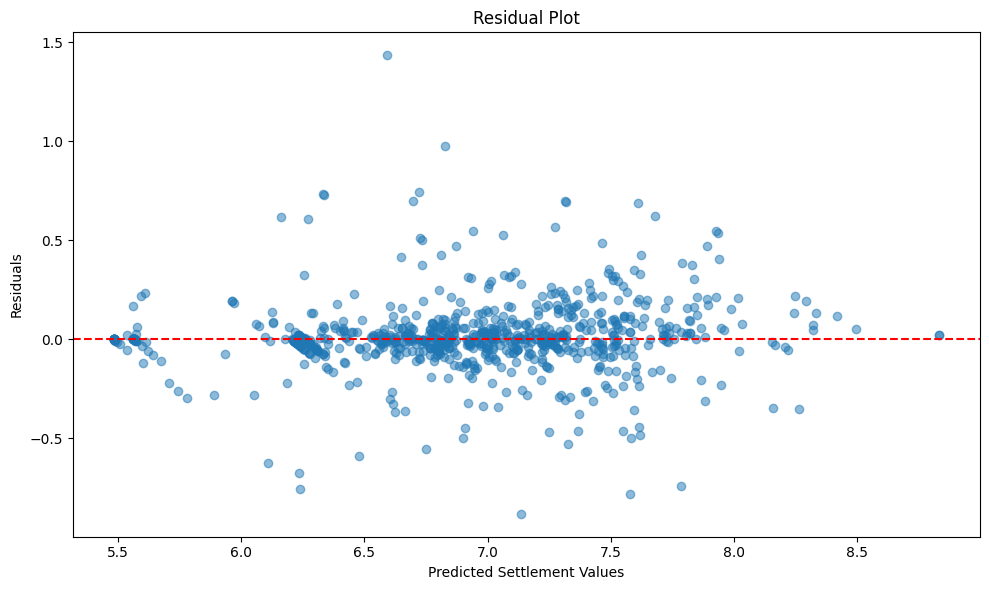

In [14]:
y_pred_test = best_pipeline.predict(X_test)

predicted_settlement_plot(y_test=y_test, y_pred_test=y_pred_test, best_model_name=best_model_name)
residual_plot(y_test=y_test, y_pred_test=y_pred_test)

In [15]:
def important_features_calc(best_pipeline):
    # Get feature names after preprocessing
    if categorical_cols:
        # Get feature names from the preprocessor
        preprocessor = best_pipeline.named_steps['preprocessor']
        feature_names = []
        
        # Get numerical feature names
        if numerical_cols:
            feature_names.extend(numerical_cols)
        
        # Get one-hot encoded feature names
        if categorical_cols:
            ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
            # Get category names from one-hot encoder
            cat_features = ohe.get_feature_names_out(categorical_cols)
            feature_names.extend(cat_features)
    else:
        feature_names = numerical_cols

    # For tree-based models, we can get feature importance directly
    if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        importances = best_pipeline.named_steps['model'].feature_importances_
        feature_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title(f'Top 20 Feature Importances ({best_model_name})')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 important features:")
        print(feature_imp.head(10))
    else:
        # For linear models, use coefficients
        if hasattr(best_pipeline.named_steps['model'], 'coef_'):
            coefs = best_pipeline.named_steps['model'].coef_
            
            if coefs.ndim == 1:  # For models with a 1D coefficient array
                feature_imp = pd.DataFrame({
                    'Feature': feature_names,
                    'Coefficient': coefs
                }).sort_values('Coefficient', key=abs, ascending=False)
                
                # Plot coefficient values
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Coefficient', y='Feature', data=feature_imp.head(20))
                plt.title(f'Top 20 Feature Coefficients ({best_model_name})')
                plt.tight_layout()
                plt.show()
                
                print("\nTop 10 features by coefficient magnitude:")
                print(feature_imp.head(10))
        else:
            # Permutation importance for models without built-in feature importance
            print("\nCalculating permutation importance...")
            perm_importance = permutation_importance(
                best_pipeline, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
            )
            
            feature_imp = pd.DataFrame({
                'Feature': feature_names,
                'Importance': perm_importance.importances_mean
            }).sort_values('Importance', ascending=False)

    return feature_imp

def permutation_importance_plotting(feature_imp):
    # Plot permutation importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
    plt.title(f'Top 20 Permutation Importances ({best_model_name})')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 features by permutation importance:")
    print(feature_imp.head(10))

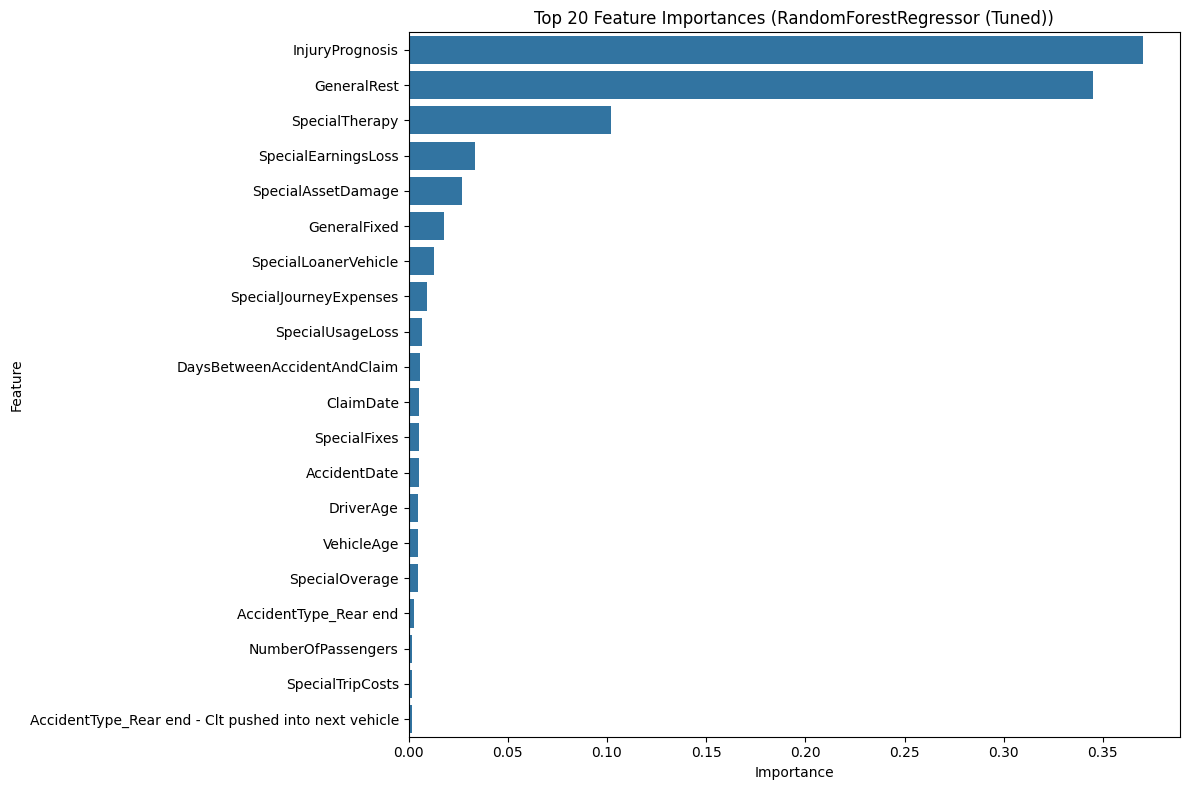


Top 10 important features:
                        Feature  Importance
0               InjuryPrognosis    0.370339
4                   GeneralRest    0.345151
17               SpecialTherapy    0.102232
6           SpecialEarningsLoss    0.033502
9            SpecialAssetDamage    0.027066
12                 GeneralFixed    0.018075
14         SpecialLoanerVehicle    0.012764
16       SpecialJourneyExpenses    0.009144
7              SpecialUsageLoss    0.006741
28  DaysBetweenAccidentAndClaim    0.005963


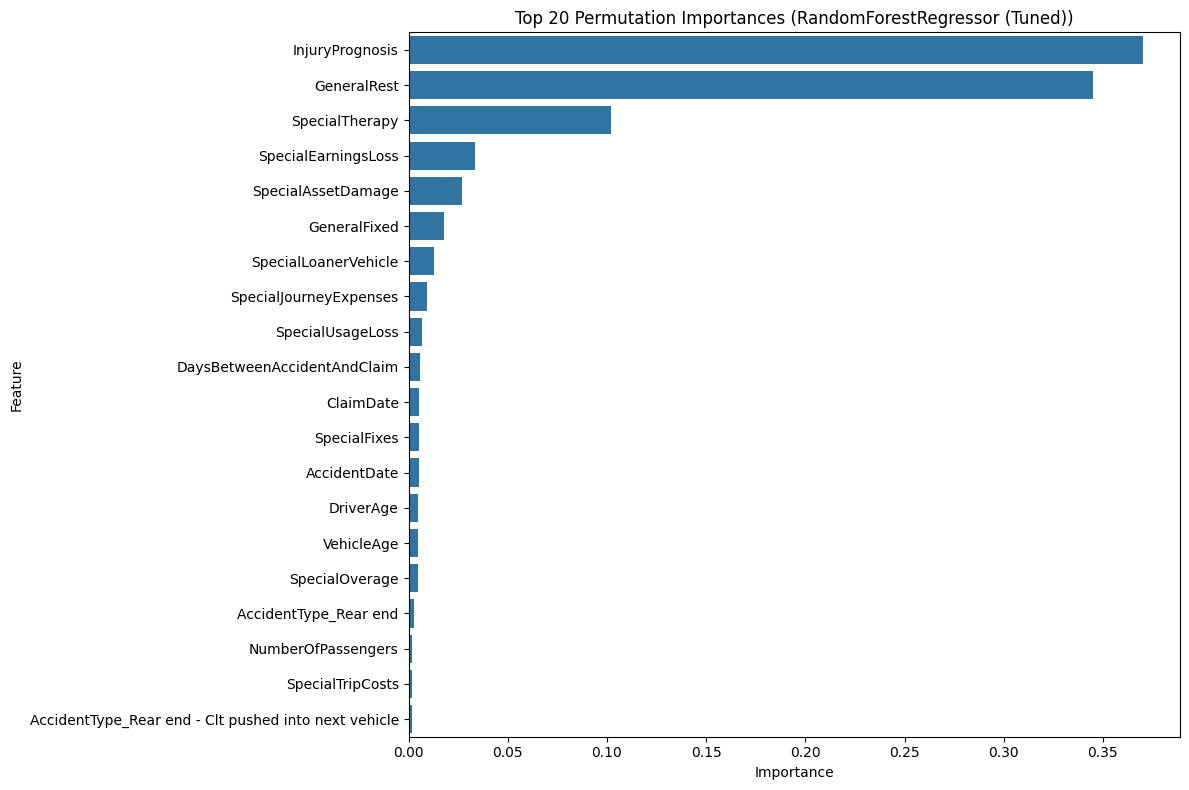


Top 10 features by permutation importance:
                        Feature  Importance
0               InjuryPrognosis    0.370339
4                   GeneralRest    0.345151
17               SpecialTherapy    0.102232
6           SpecialEarningsLoss    0.033502
9            SpecialAssetDamage    0.027066
12                 GeneralFixed    0.018075
14         SpecialLoanerVehicle    0.012764
16       SpecialJourneyExpenses    0.009144
7              SpecialUsageLoss    0.006741
28  DaysBetweenAccidentAndClaim    0.005963


In [16]:
feature_imp = important_features_calc(best_pipeline=best_pipeline)
permutation_importance_plotting(feature_imp=feature_imp)

In [17]:
def gender_bias_plot(X_test_with_preds):
    # Check for biases in predictions by protected characteristics
    if 'Gender' in X_test.columns:
        # Calculate average error by gender
        gender_errors = X_test_with_preds.groupby('Gender')['Error'].mean()
        
        print("\nAverage prediction error by gender:")
        print(gender_errors)

        # Plot gender error comparison
        plt.figure(figsize=(10, 6))
        gender_errors.plot(kind='bar')
        plt.title('Average Prediction Error by Gender')
        plt.ylabel('Mean Absolute Error')
        plt.tight_layout()
        plt.show()
    else:
        print("Gender Column not found!")
    
def age_bias_plot(X_test_with_preds):
    # Check for biases by age
    if 'DriverAge' in X_test.columns:
        # Create age groups
        X_test_with_preds['AgeGroup'] = pd.cut(X_test_with_preds['DriverAge'], 
                                            bins=[0, 30, 40, 50, 60, 70, 80],
                                            labels=['Under 30', '30-40', '40-50', '50-60', '60-70', '70-80'])
        
        # Calculate average error by age group
        age_group_errors = X_test_with_preds.groupby('AgeGroup', observed=False)['Error'].mean()

        print("\nAverage prediction error by age group:")
        print(age_group_errors)

        # Plot age group error comparison
        plt.figure(figsize=(12, 6))
        age_group_errors.plot(kind='bar')
        plt.title('Average Prediction Error by Age Group')
        plt.ylabel('Mean Absolute Error')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Age Column not found")

def bias_helper(X_test, y_test, y_pred_test):
    # Add predictions to test data
    X_test_with_preds = X_test.copy()
    X_test_with_preds['Predicted'] = y_pred_test
    X_test_with_preds['Actual'] = y_test.values
    X_test_with_preds['Error'] = abs(y_test.values - y_pred_test)

    return X_test_with_preds


X_test_with_preds = bias_helper(X_test=X_test, y_test=y_test, y_pred_test=y_pred_test)

age_bias_plot(X_test_with_preds=X_test_with_preds)
gender_bias_plot(X_test_with_preds=X_test_with_preds)

In [18]:
## Create Random Forest with only the top ten most important features

In [19]:
top_10 = list(feature_imp.head(10)['Feature'])

X_train_filtered = X_train[top_10]

preprocessor = define_preprocessor(X_train_filtered)

models = {'RandomForestRegressor': RandomForestRegressor(random_state=42),}


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


In [20]:
# Check that all features have transferred over
missing_columns = set(top_10) - set(X_train_filtered.columns)
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All top 10 features are present in the filtered dataset.")

All top 10 features are present in the filtered dataset.


In [21]:
preprocessor_tuple = define_preprocessor(claims_data)
preprocessor_obj = preprocessor_tuple[0]  

best_model_name, best_pipeline, model_results = execute_pipeline(
    models=models, 
    preprocesser=preprocessor_obj,  # Pass just the preprocessor object
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

param_grid = {
        'model__n_estimators': [100, 200, 300, 400, 500],
        'model__max_depth': [None, 10, 20, 30, 50],
        'model__min_samples_split': [2, 5],
    }

best_pipeline, best_model_name, model_results = model_tuner(
    best_pipeline, 
    param_grid, 
    model_results,
    X_train,
    y_train,
    X_val,  
    y_val   
)

# Evaluate the best model on the test set
best_pipeline = model_results[best_model_name]['pipeline']
test_results = evaluate_model(best_pipeline, X_test, y_test, best_model_name)
print(f"\nTest set evaluation for {best_model_name}:")
print(f"  RMSE: {test_results['RMSE']:.2f}")
print(f"  MAE: {test_results['MAE']:.2f}")
print(f"  R^2: {test_results['R^2']:.4f}")


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue

Training and evaluating models:
Training RandomForestRegressor...
  RandomForestRegressor - RMSE: 0.20, R^2: 0.9045, Time: 1.74s
  Error in GBP - RMSE: £333.63, MAE: £158.28

Best model based on validation RMSE: 

/var/folders/9w/v8r7h4tj4vlc3r4f4dbtctc40000gn/T/ipykernel_79892/1533445025.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names)


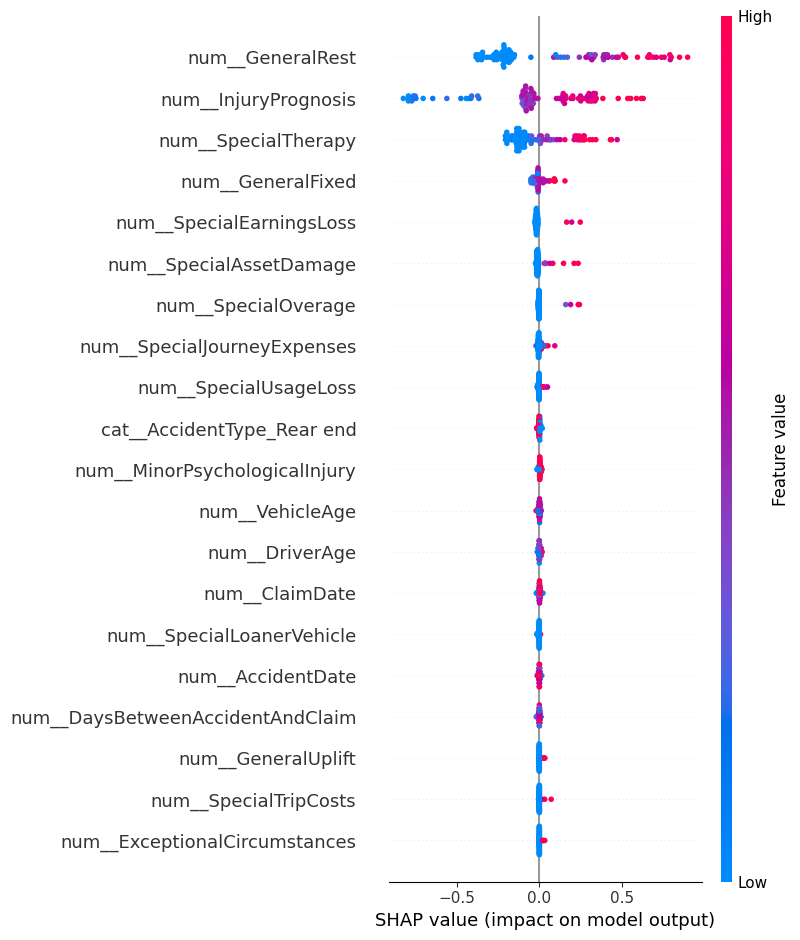

In [22]:
# For tree models, use TreeExplainer; for others fall back to KernelExplainer.
model = best_pipeline.named_steps['model']
preprocessor = best_pipeline.named_steps['preprocessor']

# Prepare a subset of validation data for explanation
X_val_sample = X_val.sample(100, random_state=42)
X_val_processed = preprocessor.transform(X_val_sample)

if hasattr(model, 'feature_importances_'):
    explainer = shap.TreeExplainer(model)
else:
    explainer = shap.KernelExplainer(model.predict, X_val_processed, link="logit")
    
# Compute SHAP values (be cautious with KernelExplainer as it can be slow)
shap_values = explainer.shap_values(X_val_processed)

# Get feature names after preprocessing
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    feature_names = X_val.columns

# Plot the summary plot
shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names)

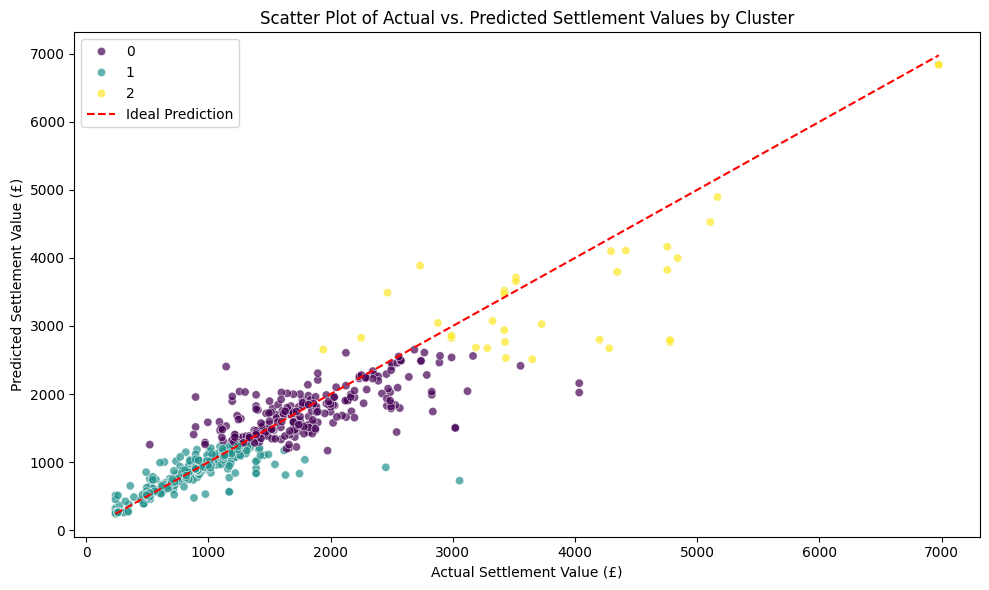

Average Prediction Error (in £) by Cluster:
   Cluster   Error_GBP
0        0  251.783603
1        1   67.493202
2        2  643.289345


In [23]:
# Create a new dataframe with actual values, predictions, and error in GBP (expm1 to reverse log transform)
X_test_with_preds = bias_helper(X_test=X_test, y_test=y_test, y_pred_test=y_pred_test)
X_test_with_preds['Actual_GBP'] = np.expm1(X_test_with_preds['Actual'])
X_test_with_preds['Predicted_GBP'] = np.expm1(X_test_with_preds['Predicted'])
X_test_with_preds['Error_GBP'] = abs(X_test_with_preds['Actual_GBP'] - X_test_with_preds['Predicted_GBP'])

# Use a simple clustering on the prediction and error space.
clustering_features = X_test_with_preds[['Predicted_GBP', 'Error_GBP']]

# Run KMeans clustering to identify 3 groups (you can change the number of clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
X_test_with_preds['Cluster'] = kmeans.fit_predict(clustering_features)

# Plot the scatter of Actual vs Predicted claim values, colored by cluster assignment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_test_with_preds, x='Actual_GBP', y='Predicted_GBP', hue='Cluster', palette='viridis', alpha=0.7)
plt.plot([X_test_with_preds['Actual_GBP'].min(), X_test_with_preds['Actual_GBP'].max()],
         [X_test_with_preds['Actual_GBP'].min(), X_test_with_preds['Actual_GBP'].max()],
         'r--', label='Ideal Prediction')
plt.xlabel('Actual Settlement Value (£)')
plt.ylabel('Predicted Settlement Value (£)')
plt.title('Scatter Plot of Actual vs. Predicted Settlement Values by Cluster')
plt.legend()
plt.tight_layout()
plt.show()

# Report average error in each cluster
cluster_error = X_test_with_preds.groupby('Cluster')['Error_GBP'].mean().reset_index()
print("Average Prediction Error (in £) by Cluster:")
print(cluster_error)

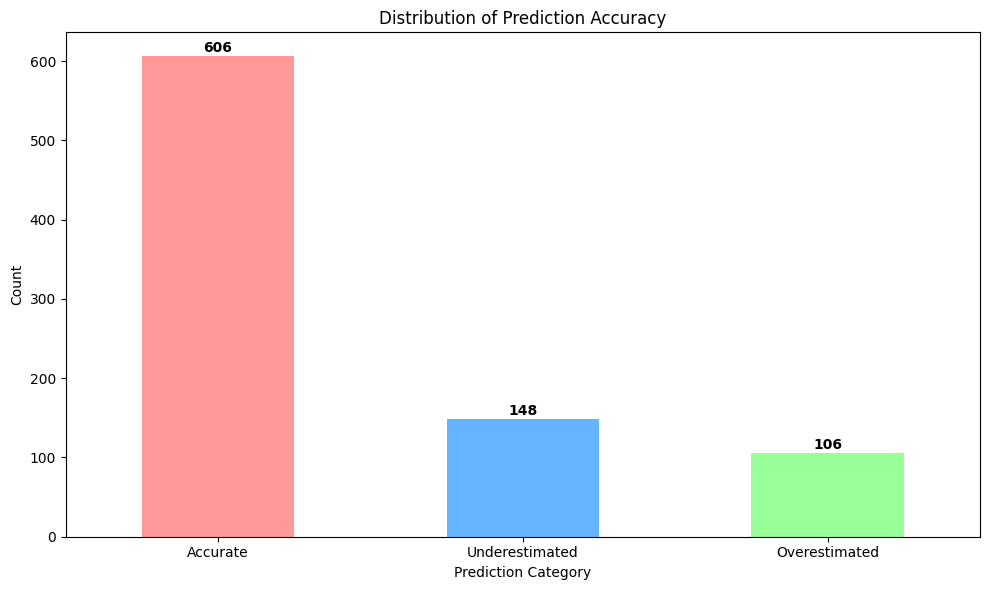

Percentage of predictions by category:
Accurate: 70.5%
Underestimated: 17.2%
Overestimated: 12.3%


In [24]:
# Create a new dataframe to analyze prediction accuracy
accuracy_analysis = X_test_with_preds.copy()

# Calculate the difference (actual - predicted)
accuracy_analysis['Difference'] = accuracy_analysis['Actual'] - accuracy_analysis['Predicted']

# Categorize predictions
accuracy_analysis['Prediction_Category'] = pd.cut(
    accuracy_analysis['Difference'],
    bins=[-float('inf'), -0.1, 0.1, float('inf')],
    labels=['Overestimated', 'Accurate', 'Underestimated']
)

# Count the number of predictions in each category
category_counts = accuracy_analysis['Prediction_Category'].value_counts()

# Plot the results
plt.figure(figsize=(10, 6))
ax = category_counts.plot(kind='bar', color=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Distribution of Prediction Accuracy')
plt.xlabel('Prediction Category')
plt.ylabel('Count')

# Add count labels on top of each bar
for i, v in enumerate(category_counts):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print percentage breakdown
percentages = (category_counts / len(accuracy_analysis) * 100).round(1)
print("Percentage of predictions by category:")
for category, percentage in percentages.items():
    print(f"{category}: {percentage}%")

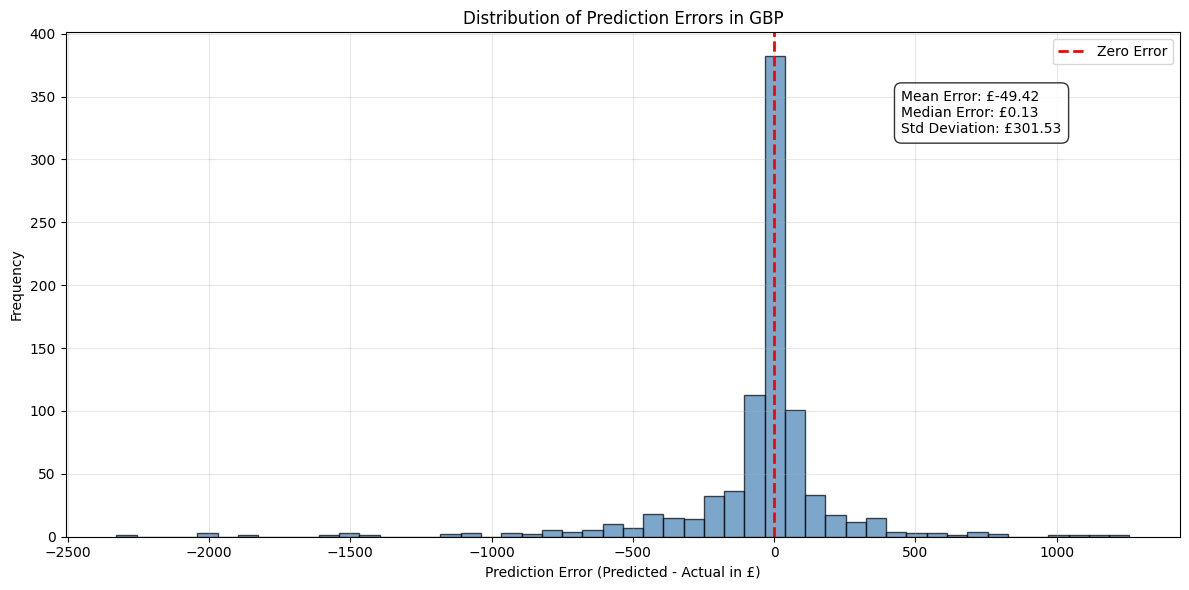

In [25]:
# Calculate the difference between predicted and actual values in GBP
X_test_with_preds['Difference_GBP'] = X_test_with_preds['Predicted_GBP'] - X_test_with_preds['Actual_GBP']

# Create a histogram of the differences
plt.figure(figsize=(12, 6))
plt.hist(X_test_with_preds['Difference_GBP'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')

# Add labels and title
plt.xlabel('Prediction Error (Predicted - Actual in £)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors in GBP')

# Add statistics to the plot
mean_error = X_test_with_preds['Difference_GBP'].mean()
median_error = X_test_with_preds['Difference_GBP'].median()
std_error = X_test_with_preds['Difference_GBP'].std()

stats_text = f'Mean Error: £{mean_error:.2f}\nMedian Error: £{median_error:.2f}\nStd Deviation: £{std_error:.2f}'
plt.annotate(stats_text, xy=(0.75, 0.8), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

plt.legend()
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()